# Second Fine Tune GPT-2 Model

Hint: Use the dialogs.txt file to train the model on google colab.

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
def save_in_google(file_name, obj=None):
    try:
        google_path = "/content/gdrive/My Drive/"
        cur_path = f"{google_path}{file_name}"
        if file_name.endswith(".pt") or file_name.endswith(".pth"):
            torch.save(model.state_dict(), cur_path)
        elif file_name.endswith(".pkl"):
            with open(cur_path, 'wb') as f:
                pickle.dump(obj, f)
        elif file_name.endswith(".png"):
            plt.savefig(cur_path)
        elif file_name.endswith(".txt"):
            with open(cur_path, "w") as f:
                f.write(obj)

        print(f"Succefull saved {file_name} in google ({dt.now().strftime('%d.%m.%Y - %H:%M:%S')})")
    except Exception:
        print(f"Failed to save {file_name} in google ({dt.now().strftime('%d.%m.%Y - %H:%M:%S')})")

### System

In [30]:
!python --version

Python 3.10.12


In [31]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan  6 12:19:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [32]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [33]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

In [34]:
!cat /proc/meminfo

MemTotal:       13290480 kB
MemFree:         6929320 kB
MemAvailable:   11432008 kB
Buffers:          370948 kB
Cached:          4314516 kB
SwapCached:            0 kB
Active:           718412 kB
Inactive:        5309392 kB
Active(anon):       1136 kB
Inactive(anon):  1342944 kB
Active(file):     717276 kB
Inactive(file):  3966448 kB
Unevictable:          16 kB
Mlocked:              16 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              2072 kB
Writeback:             0 kB
AnonPages:       1340788 kB
Mapped:           523644 kB
Shmem:              1732 kB
KReclaimable:     119808 kB
Slab:             163816 kB
SReclaimable:     119808 kB
SUnreclaim:        44008 kB
KernelStack:        5712 kB
PageTables:        28264 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6645240 kB
Committed_AS:    3156844 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       76296 kB
VmallocChunk:    

### Imports

In [35]:
#!python -m pip install torch
#!python -m pip install transformers

In [36]:
#from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from datetime import datetime as dt

import json

import transformers
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

In [37]:
os.listdir("./")

['.config',
 'model',
 '.ipynb_checkpoints',
 'gdrive',
 'dialogs.txt',
 'sample_data']

### Load and Prepare the data

In [38]:
start_sentences = [
    "Create me a unique interactive story to calm with the topic:",
    "Generate a unique interactive story for relaxation on the topic:",
    "Craft a unique interactive narrative to soothe with the theme:",
    "Design a unique interactive tale for calming with the subject:",
    "Produce a unique interactive saga to unwind with the topic:",
    "Compose a unique interactive chronicle for tranquility with the theme:",
    "Formulate a unique interactive anecdote to de-stress with the subject:",
    "Devise a distinctive interactive fable for serenity with the topic:",
    "Invent a one-of-a-kind interactive parable for peace with the theme:",
    "Create an exclusive interactive yarn for tranquility with the subject:",
    "Form a novel interactive narrative for calmness with the topic:",
    "Construct a unique interactive tale for relaxation with the theme:",
    "Develop an original interactive story for soothing with the subject:",
    "Visualize me following topic:",
    "Picture me following subject:",
    "Imagine me pursuing theme:",
    "Envision me tracking topic:",
    "See me following subject:",
    "Conceive me chasing theme:",
    "Create me a unique interactive story to calm with the topic",
    "Generate a unique interactive story for relaxation on the topic",
    "Craft a unique interactive narrative to soothe with the theme",
    "Design a unique interactive tale for calming with the subject",
    "Produce a unique interactive saga to unwind with the topic",
    "Compose a unique interactive chronicle for tranquility with the theme",
    "Formulate a unique interactive anecdote to de-stress with the subject",
    "Devise a distinctive interactive fable for serenity with the topic",
    "Invent a one-of-a-kind interactive parable for peace with the theme",
    "Create an exclusive interactive yarn for tranquility with the subject",
    "Form a novel interactive narrative for calmness with the topic",
    "Construct a unique interactive tale for relaxation with the theme",
    "Develop an original interactive story for soothing with the subject",
    "Visualize me following topic",
    "Picture me following subject",
    "Imagine me pursuing theme",
    "Envision me tracking topic",
    "See me following subject",
    "Conceive me chasing theme"
]

In [39]:
MODEL_PATH = "./model/model.pth"
MODEL_WEIGHT_PATH = "./model/model_weights.pth"
ONNX_PATH = "./model/model.onnx"
MAX_LENGTH = 1024   #"auto"
# ".pt", ".pth", ".pkl", or ".h5"

class Dialog_Data(Dataset):

    def __init__(self, tokenizer, data_dir_path="./data", read_one_file=False, should_save_as_one_file=True):
        self.tokenizer = tokenizer
        self.data_dir_path = data_dir_path
        self.read_data(data_dir_path, read_one_file, should_save_as_one_file)

    def read_data(self, data_dir_path, read_one_file, should_save_as_one_file=True):
        global MAX_LENGTH

        data = []
        conversations = []
        if read_one_file:
            with open("./dialogs.txt", "r", encoding="latin1") as f:
                raw = f.read()
            for dialog in raw.split("#/"):
                cur_conversation = []
                for sentence in dialog.split(";"):
                    data += [sentence]
                    cur_conversation += [sentence]
                conversations += [(cur_conversation)]
        else:
            if type(self.data_dir_path) != list:
                self.data_dir_path = [self.data_dir_path]
            for dataset_path in self.data_dir_path:
                for dialog in os.listdir(dataset_path):
                        with open(f"{dataset_path}/{dialog}", "r") as f:
                            cur_conversation = []
                            for idx, line in enumerate(f.read().split("\n")):
                                content = ":".join(line.split(":")[1:]).strip()
                                if len(content) > 0:
                                    if dataset_path == "./data_stories" and idx == 0:
                                        start = np.random.choice(start_sentences)
                                        data += [f"{start} {content}"]
                                        cur_conversation += [f"{start} {content}"]
                                    else:
                                        data += [content]
                                        cur_conversation += [content]
                        conversations += [(cur_conversation)]
            if should_save_as_one_file:
                save_data = ""
                for idx_1, dialog in enumerate(conversations):
                    if idx_1 > 0:
                        save_data += "#/"

                    for idx_2, elem in enumerate(dialog):
                        if idx_2 == 0:
                            save_data += f"{elem}"
                        else:
                            save_data += f";{elem}"
                    with open("./dialogs.txt", "w") as f:
                        f.write(save_data)

        # add markers and trim
        X = []
        y = []
        is_conversation_beginning = []
        for cur_conversation in conversations:
            for idx in range(0, len(cur_conversation)-1, 2):
                if idx == 0:
                    is_conversation_beginning += [1]
                else:
                    is_conversation_beginning += [0]
                X += [cur_conversation[idx]]
                y += [cur_conversation[idx+1]]

        self.conversations = conversations
        self.X = X
        self.y = y
        self.is_conversation_beginning = is_conversation_beginning

        # encoded_data = self.tokenizer(self.X, truncation=True, return_tensors="pt", max_length=MAX_LENGTH, padding="max_length") # max_length=40, padding="max_length"
        # self.X_encoded = encoded_data['input_ids']
        # self.X_attention_mask = encoded_data['attention_mask']

        encoded_data = self.tokenizer(self.y, truncation=False, return_tensors="pt", max_length=MAX_LENGTH, padding="max_length")
        self.y_encoded =  encoded_data['input_ids']
        self.y_attention_mask = encoded_data['attention_mask']

    def get_context(self, idx):
        with_context = ""
        cur_idx = idx
        while cur_idx >= 0:
            if cur_idx == idx:
                with_context += f"<bot>{self.y[cur_idx]}<end>"
                with_context = f"{self.X[cur_idx]}{with_context}"
            else:
                with_context = f"{self.y[cur_idx]}<sep>{with_context}"
                with_context = f"{self.X[cur_idx]}<sep>{with_context}"
            if self.is_conversation_beginning[cur_idx] == 1:
                break
            cur_idx -= 1
        #with_context = f"<start>{with_context}"
        return with_context

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.get_context(idx)
        encoded_data = self.tokenizer(X, truncation=True, return_tensors="pt", max_length=MAX_LENGTH, padding="max_length")
        return (encoded_data['input_ids'], encoded_data['attention_mask'])#, self.y_encoded[idx])



In [40]:
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2", padding_side="right")
tokenizer.add_special_tokens({  "pad_token": "<pad>",
                                "eos_token": "<end>",
                                "sep_token": "<sep>"})
tokenizer.add_tokens(["<bot>"])

1

In [41]:
data = Dialog_Data(tokenizer=tokenizer, data_dir_path=["./data_stories", "./data_calm_bot", "./data"],
                    read_one_file=True, should_save_as_one_file=True)
data = DataLoader(data, batch_size=4, shuffle=True)

In [42]:
# check the data
[print(i, "\n") for i in data.dataset.X[:3]];

Imagine me pursuing theme: Ocean. 

Yes, I can feel it. It's so inviting and peaceful. 

I am focusing on the sounds of the waves, feeling them melting away my tension. It's like a lullaby for the soul. 



In [43]:
data.dataset.get_context(3)

"Imagine me pursuing theme: Ocean.<sep>Ah, the ocean. Such a vast, serene place. Close your eyes for a moment and take a deep breath, imagining the salty scent of the sea. Now, picture yourself standing on a beautiful sandy beach, the warmth of the golden sun touching your skin. Can you feel it?<sep>Yes, I can feel it. It's so inviting and peaceful.<sep>As you stand there, listen closely. Can you hear the gentle rhythm of the waves washing ashore? It's as if the ocean is whispering a calming melody just for you. Take a moment to tune in and let these soothing sounds wash away any stress or worries you may have.<sep>I am focusing on the sounds of the waves, feeling them melting away my tension. It's like a lullaby for the soul.<sep>Now, let your imagination guide you towards the water's edge. As you approach, notice how the sand feels beneath your feet - soft and welcoming, with each grain embracing your toes. With each step, feel the water softly brush against your feet, refreshing and

In [44]:
data.dataset.get_context(10)

"See me following subject Chocolate factory.<sep>Ah, the magical world of a chocolate factory! Close your eyes and let your imagination take you on a journey. Picture yourself standing in front of a grand, golden gate, adorned with intricate cocoa bean patterns. As you enter through the gate, you are greeted by the sweet aroma of chocolate in the air.<sep>I can smell it! What do I see inside?<sep>As you step inside, you find yourself surrounded by sparkling chocolate rivers, flowing effortlessly through the factory. The rivers are made up of the finest milk, dark, and white chocolate, each with its unique velvety texture and rich flavor.<sep>The rivers look so inviting! Can I dip my fingers in?<sep>Of course! As you dip your fingers into the chocolate rivers, you feel the warm, smooth chocolate embracing your skin. It's as if the rivers are gentle, comforting caresses, soothing your worries away. Take a moment to savor the feeling of calmness and relaxation flowing through your fingert

In [45]:
data.dataset.get_context(203)

"Develop an original interactive story for soothing with the subject: Witch cottage.<sep>Ah, a witch cottage. That's an intriguing choice. Let me tell you the tale of the enchanting witch cottage nestled deep within a mystical forest.<sep>I'm all ears.<sep>Once upon a time, in a land far away, there lived a wise and gentle witch. Her name was Seraphina, and her cottage was a magical haven amidst the towering trees. Picture a cozy thatched roof with wildflowers peeking out, and walls covered in vibrant ivy.<sep>I can see it now.<sep>Seraphina, with her twinkling eyes and flowing gray hair, had a secret garden filled with aromatic herbs and colorful blooms. The air around her cottage was always filled with the sweet scent of chamomile and lavender. Can you take a moment to inhale deeply and imagine that soothing aroma?<sep>*takes a deep breath* I can almost smell it.<sep>That's wonderful. Seraphina had a unique ability to use her herbs and potions to bring peace and tranquility to those 

In [46]:
len(data.dataset)

47518

In [47]:
# # Test saved dialogs in one file
# counter = 0
# with open("./dialogs.txt", "r") as f:
#     dialogs = f.read()
# print(f"Dialogs amount: {len(os.listdir('./data'))}")
# print(f"In one file dialogs amount: {len(dialogs.split('#'))}")

In [48]:
BATCH_AMOUNT = 0
for X, a in data:
    BATCH_AMOUNT += 1
    if BATCH_AMOUNT == 5:
        print("X:")
        print("Decoded:", tokenizer.decode(X[0][0]))
        print("Encoded:", X[0])
        print(type(X[0]))
        print(len(X[0]))
        print("AttentionMask:\n", a[0])
        print(type(a[0]))
        print(len(a[0]))
        # print("Target:\nDecoded:", tokenizer.decode(y[0][0]))
        # print("Encoded:", y[0])
        # print(type(y[0]))
        # print(len(y[0]))

BATCH_AMOUNT

X:
Decoded: Produce a unique interactive saga to unwind with the topic Xanadu City.<sep>Ah, my friend, you've stumbled upon a name that holds great beauty and tranquility. Close your eyes and imagine yourself in a peaceful place, surrounded by lush greenery and gentle sounds. Take a deep breath and let the calmness wash over you.<sep>Okay, I'm ready. Tell me more about this Xanadu City.<sep>Picture yourself standing at the entrance of this grand city, adorned with vibrant flowers and towering trees. As you step inside, a soft breeze whispers through your hair, carrying a delicate scent of fragrant blossoms. Can you feel the gentle touch of the breeze?<sep>Yes, it's so refreshing. I can almost feel it on my skin.<sep>Very good. Now, take a moment to notice the colors around you. Can you describe the shades and hues that paint this picture-perfect city?<sep>I see a palette of serene blues, soothing greens, and warm golds. The buildings are gracefully designed, with intricate patterns and

11880

### Load pretrained model

In [49]:
model = transformers.GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.eval()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

In [51]:
model = model.to(device)

In [52]:
save_in_google("test_model.pt")

Succefull saved test_model.pt in google (06.01.2024 - 12:22:33)


In [53]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/model.pt", map_location=device))

<All keys matched successfully>

### First test

In [54]:
def inference(prompt:str, model, tokenizer, device, padding, clear_output=True):
    model.eval()
    prompt = f"{prompt}<bot>"
    prompt = tokenizer(prompt, return_tensors="pt", padding=padding)
    X = prompt["input_ids"].to(device)
    a = prompt["attention_mask"].to(device)
    with torch.no_grad():
        output = model.generate(X, attention_mask=a, pad_token_id=tokenizer.pad_token_id,
                                                        do_sample=True, max_length=MAX_LENGTH)

    if clear_output:
        output = tokenizer.decode(output[0], skip_special_tokens=True)
    else:
        output = tokenizer.decode(output[0], skip_special_tokens=False)

    if type(output) == list and len(output) == 1:
        output = output[0]
    return output

In [55]:
inference(prompt="Hey, I'm feeling not so good.", model=model, tokenizer=tokenizer,
                                                        device=device, padding="max_length", clear_output=True)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 1024, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


"Hey, I'm feeling not so good.<bot>"

In [56]:
inference(prompt="Hey, I've been feeling really down lately.", model=model, tokenizer=tokenizer, device=device, padding="max_length", clear_output=False)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 1024, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


"Hey, I've been feeling really down lately.<bot><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

### Fine Tune Model

In [57]:
def print_time_information(start, end=None, total_seconds=None, text="Total training time:", should_print=True):
    if type(total_seconds) is type(None):
        if type(end) is type(None):
            end = dt.now()
        total_seconds = abs((start-end).total_seconds())

    minutes, seconds = divmod(total_seconds, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    res = f"{text}\n    -> {int(days)} Days\n    -> {int(hours)} Hours\n    -> {int(minutes)} Minutes\n    -> {int(seconds)} Seconds"
    if should_print:
        print(res)
    return res

def calculate_train_duration(epoch_start, batch_amount, epochs, cur_epoch):
    """
    Call this function once after the first batch every epoch.
    """
    cur_epoch += 1
    now = dt.now()
    duration_one_batch = abs((epoch_start-now).total_seconds())
    duration_for_one_epoch = duration_one_batch * batch_amount
    epochs_left = (epochs - cur_epoch) + 1    # current epoch also have to run
    predicted_training_duration = epochs_left * duration_for_one_epoch
    res = f"{'-'*16}\n"
    text = f"Training will need about following time for {epochs_left} epochs:"
    res += print_time_information(start=epoch_start, total_seconds=predicted_training_duration, text=text, should_print=False)
    res += f"\n{'-'*16}"
    print(res)
    return res

def get_short_duration_representation(duration, should_print=False):
    minutes, seconds = divmod(duration, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    res = f"{int(days)}D {int(hours)}H {int(minutes)}M {int(seconds)}S"
    if should_print:
        print(res)
    return res

In [58]:
test_1 = dt.now()

In [59]:
get_short_duration_representation(abs((test_1-dt.now()).total_seconds()))

'0D 0H 0M 0S'

In [60]:
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 8

loss_hist = []
steps = 0

solutions = []
solutions_cleared = []
epoch_durations = []

start = dt.now()
log = f"Model V6 Trainstart: {start.strftime('%d.%m.%Y - %H:%M:%S')}"

with open("./log.txt", "w") as f:
    f.write(f"Log File for Training Calm Chatbot {start.strftime('%d.%m.%Y - %H:%M:%S')}")

for cur_epoch in range(0, epochs):
    model.train()
    epoch_start = dt.now()
    new_epoch = True
    for input_ids, attention_masks in data:
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        optimizer.zero_grad()
        loss = model(input_ids, attention_mask=attention_masks, labels=input_ids).loss
        loss_hist += [loss.item()]
        loss.backward()
        optimizer.step()
        steps += 1

        if new_epoch:
            time_prediction = calculate_train_duration(epoch_start, BATCH_AMOUNT, epochs, cur_epoch)
            new_epoch = False

            with open("./log.txt", "a") as f:
                f.write(f"\n\n{time_prediction}")

    torch.save(model.state_dict(), f"./model_state_V5_{cur_epoch+1}.pt")
    epoch_info = f'Epoch {cur_epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Steps: {steps}, Current Time:{dt.now().strftime("%H:%M:%S")}'
    print(epoch_info)
    test_prompt = inference(prompt="Hey, I'm feeling not so good.", model=model, tokenizer=tokenizer,
                                                        device=device, padding=True, clear_output=False)
    solutions += [test_prompt]
    solutions_cleared += [inference(prompt="Hey, I'm feeling not so good.", model=model, tokenizer=tokenizer,
                                                        device=device, padding=True, clear_output=True)]

    epoch_durations += [abs((epoch_start-dt.now()).total_seconds())]

    with open("./log.txt", "a") as f:
        try:
            f.write(f"\n\n{epoch_info}\nEpoch-Duration: {get_short_duration_representation(epoch_durations[-1])}\n\nTest-Prompt:\n{test_prompt}")
            log += f"\n\n{epoch_info}\nEpoch-Duration: {get_short_duration_representation(epoch_durations[-1])}"
        except Exception:
            pass

duration = abs((start-dt.now()).total_seconds())
log += print_time_information(start=epoch_start, total_seconds=duration, text="\n\nTraining duration:", should_print=False)

----------------
Training will need about following time for 8 epochs:
    -> 0 Days
    -> 20 Hours
    -> 38 Minutes
    -> 10 Seconds
----------------
Epoch 1/8, Training Loss: 0.1573, Steps: 11880, Current Time:13:42:08
----------------
Training will need about following time for 7 epochs:
    -> 0 Days
    -> 4 Hours
    -> 6 Minutes
    -> 3 Seconds
----------------
Epoch 2/8, Training Loss: 0.2826, Steps: 23760, Current Time:15:01:59
----------------
Training will need about following time for 6 epochs:
    -> 0 Days
    -> 3 Hours
    -> 27 Minutes
    -> 3 Seconds
----------------
Epoch 3/8, Training Loss: 0.1141, Steps: 35640, Current Time:16:21:52
----------------
Training will need about following time for 5 epochs:
    -> 0 Days
    -> 2 Hours
    -> 56 Minutes
    -> 3 Seconds
----------------
Epoch 4/8, Training Loss: 0.0164, Steps: 47520, Current Time:17:41:47
----------------
Training will need about following time for 4 epochs:
    -> 0 Days
    -> 2 Hours
    -> 21 M

In [61]:
#print_time_information(start)

# plot loss
# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# ax.plot(np.arange(len(loss_hist)), loss_hist[:], label='Loss')
# ax.set_xlabel('Learning progress')
# ax.set_ylabel('Loss (normalized mean absolute error)')
# ax.set_title('Loss over time')
# ax.legend()
# ax.grid()

# save step solution-predictions:
with open("./result_per_epoch.txt", "w") as f:
    res = ""
    for i, cur_res in enumerate(solutions, start=1):
        res += f"\n{'-'*16}\n{i:02d}. Epoch:\n{cur_res}"
    f.write(res)

UnicodeEncodeError: 'ascii' codec can't encode character '\ufffd' in position 833: ordinal not in range(128)

In [ ]:
with open("./cleared_result_per_epoch.txt", "w") as f:
    res = ""
    for i, cur_res in enumerate(solutions_cleared, start=1):
        res += f"\n{'-'*16}\n{i:02d}. Epoch:\n{cur_res}"
    f.write(res)

In [62]:
import pickle

with open('./loss_hist.pkl', 'wb') as f:
    pickle.dump(loss_hist, f)

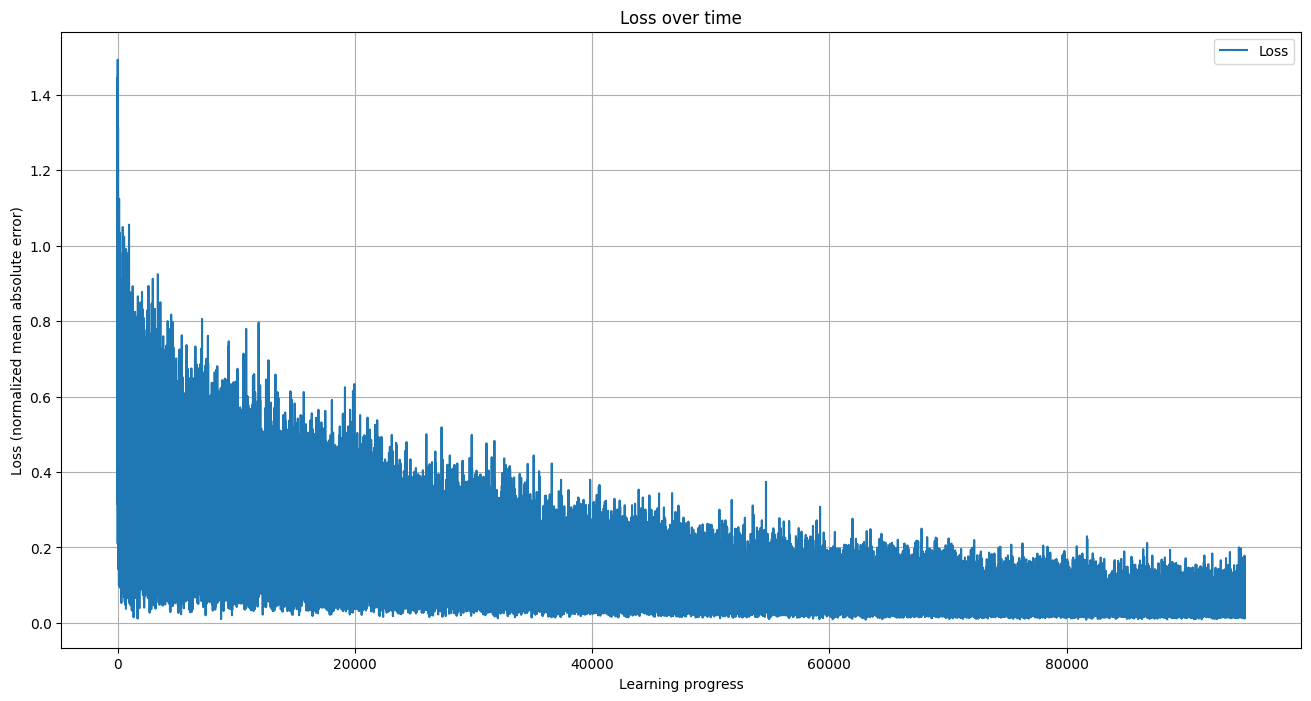

In [63]:
# plot loss
OFFSET = 0
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(np.arange(len(loss_hist)-OFFSET), loss_hist[OFFSET:], label='Loss')
ax.set_xlabel('Learning progress')
ax.set_ylabel('Loss (normalized mean absolute error)')
ax.set_title('Loss over time')
ax.legend()
ax.grid()
plt.savefig("/content/gdrive/My Drive/model_V6_loss.png")

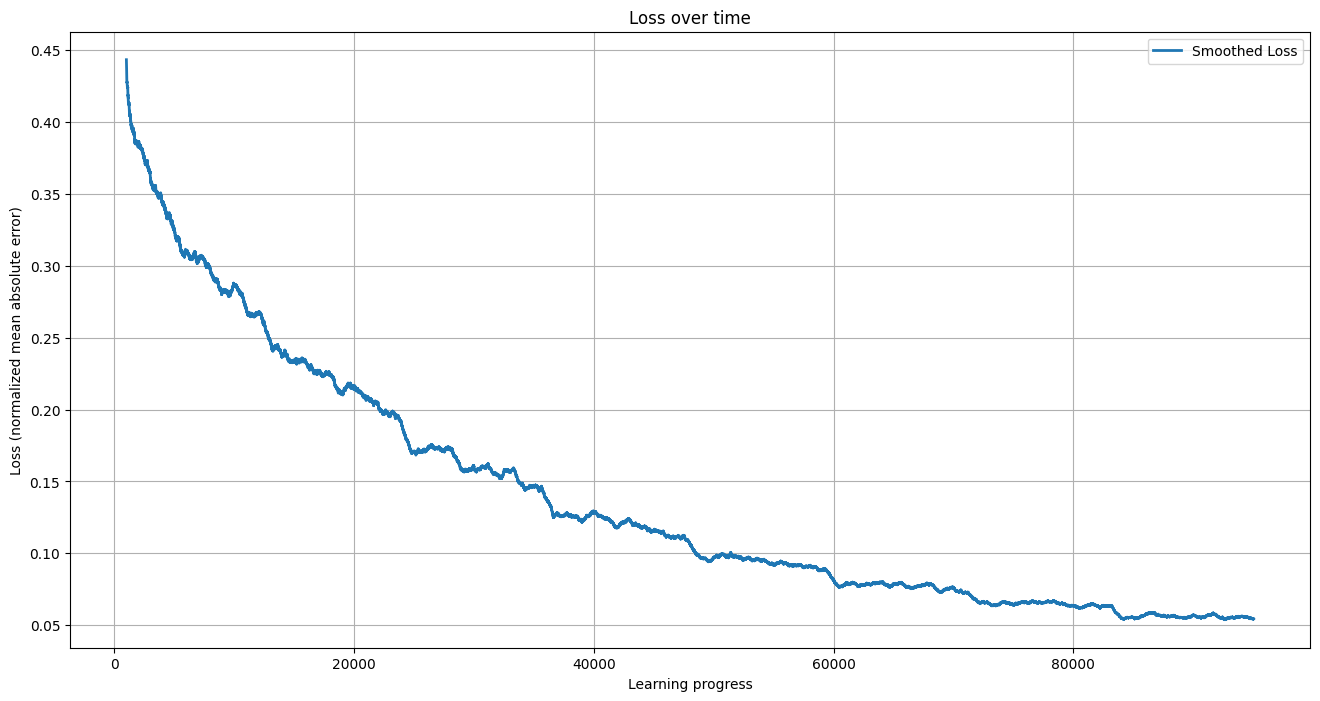

In [64]:
import matplotlib.ticker as mticker

OFFSET = 0
loss_series = pd.Series(loss_hist[OFFSET:])

# Wenden Sie das gleitende Fenster an
window_size = 1000  # Größe des gleitenden Fensters
loss_rolling = loss_series.rolling(window=window_size).mean()

# Zeichnen Sie die ursprünglichen und geglätteten Daten
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#ax.plot(np.arange(len(loss_hist)), loss_hist, label='Original Loss')
ax.plot(np.arange(len(loss_series.index)), loss_rolling, label='Smoothed Loss', linewidth=2)
ax.set_xlabel('Learning progress')
ax.set_ylabel('Loss (normalized mean absolute error)')
ax.set_title('Loss over time')
ax.legend()
ax.grid()
# formatter = mticker.ScalarFormatter()
# formatter.set_scientific(False)
# ax.yaxis.set_major_formatter(formatter)
# ax.set_yscale('log')

plt.savefig("/content/gdrive/My Drive/model_V6_loss_smoothed.png")
plt.show()


### Save model

-> Propably save the model in a extra repository/branch and provide it as python module<br>
-> Is model very big?

save only weights

In [ ]:
torch.save(model.state_dict(), MODEL_WEIGHT_PATH)

# loading
# config = transformers.GPT2Config.from_pretrained("gpt2")
# config.max_length = MAX_LENGTH #config.task_specific_params['text-generation']['max_length']
# model = transformers.GPT2LMHeadModel.from_pretrained("gpt2", config=config)
# model.resize_token_embeddings(len(tokenizer))
# model.load_state_dict(torch.load(MODEL_WEIGHT_PATH))
# model.eval()

save whole model

In [ ]:
torch.save(model, MODEL_PATH)

# loading
# model = torch.load(MODEL_PATH)
# model.eval()

save in Google Drive

In [ ]:
save_in_google("model_V6_12.pt")

In [ ]:
save_in_google("model_V6_loss_hist.pkl", loss_hist)

In [ ]:
save_in_google("model_V6_log.txt", log)

---
### Ressources:

- https://www.toolify.ai/ai-news/finetuning-gpt2-for-conversational-chatbots-10476
- https://huggingface.co/docs/transformers/model_doc/gpt2
- [PyTorch kompakt](https://www.thalia.de/shop/home/artikeldetails/A1062166688)
- https://pytorch.org/tutorials/beginner/chatbot_tutorial.html
- https://github.com/itsuncheng/fine-tuning-GPT2/tree/master
- https://www.kaggle.com/code/pinooxd/gpt2-chatbot/notebook

<br>

---